# TrackSubtract 
Automatic removal of copyrighted music from audio streams.

2018.06.07 MPKT

## Goal
Most major video-sharing platforms scan content for copyrighted audio. When infringing audio is detected in the background of a file, it is either deleted or muted. Either option results in fewer files, less revenue, and frustrated users. TrackSubtract provides a one-click product for removing unwanted copyrighted music from any audio file.

## Algorithm
A user submits an audiofile labeled `Mixed` that contains both the desired audio and a undesirable background song.
-  A music identification service (such as the open-source EchoPrint) identifies the song track in the background
-  A file containing labeled `UndesiredTrue` is obtained, containing a clean version.
-  Signal correlation between the `Mixed` and `UndesiredTrue` is calculated as a function of lag time to identify the temporal offset.
-  A sliding correction window (in the time domain) will scan over the song to match the amplitude of `UndesiredTrue` to `Mixed` before subtraction, since this will vary over the course of the recording. Thus the pre-subtraction signal attenuation factor (*A*) is empirically determined as a function of time.
-  In real situations, the attenuation will not be consistent across all frequencies (trivial example: music that was accidentally recorded while being played from a phone speaker will not contain the bass frequencies that are present in `UndesiredTrue`). Consequently, it may be helpful to pass a sliding frequency window within the sliding time window. In this case, the pre-subtraction signal attenuation (*A*) is a calculated as a function of time and frequency.
-  The `UndesiredTrue` is waveform is inverted, scaled by *A*, and added to `Mixed`.

## Quick Eqns
Only taking into account the temporal offset, this can be conceptualized as: `Mixed(t) = Signal(t) + A*Song(t+temporalOffset)`, thus, `Signal(t) = SignalAndSong(t) - A*Song(t+temporalOffset)`

Taking into account (by sliding windows) that the attenuation is a function of both time and frequency: `Signal(t,f) = SignalAndSong(t,f) - *A(t,f)*\*Song(t+temporalOffset,f)`

## Data
The `UndesiredTrue` file contains a recording of the song "Hey" from the BenSound.com royalty-free audio website.

The `Mixed` file contains a recording of me talking, while "Hey" plays in the background.

# Preparation

## Settings

In [1]:
# Filenames
Mixed_Filename = 'SongAndSignal.wav';
Undesired_True_Filename = 'SongTrue_MONO_Short.wav';

# Set time range in seconds, if working with subset
# Set to 0 to use the entire file
TrimMixed_s1_s2 = (5,7)
TrimUndesiredTrue_s1_s2 = (5.1,7.1)

# Set absolute value of maximum lag if known (seconds)
max_lag_s = 0.45

# Verbosity (0/1)
qVerbose = 2; # 1= text feedback, 2 = plot feedback
qSillyWaveformSubtraction = 0; # show nonsense attempt to subtract waveforms

## Import necessary libraries

In [2]:
from scipy.io.wavfile import read as wavread # import files
import matplotlib.pyplot as plt 
import numpy as np
import operator # for finding max values
import seaborn as sns # for the Pxx heatmaps

## Import the files

In [3]:
# actual import
UndesiredTrueRate, UndesiredTrueTimeseries = wavread(Undesired_True_Filename)
MixedRate, MixedTimeseries = wavread(Mixed_Filename)

# Trim the files, if requested
if TrimMixed_s1_s2 != 0:
    MixedTimeseries = MixedTimeseries[(round(MixedRate*TrimMixed_s1_s2[0])):(round(MixedRate*TrimMixed_s1_s2[1]))]
if TrimUndesiredTrue_s1_s2 != 0:
    UndesiredTrueTimeseries = UndesiredTrueTimeseries[(round(UndesiredTrueRate*TrimUndesiredTrue_s1_s2[0])):(round(UndesiredTrueRate*TrimUndesiredTrue_s1_s2[1]))]

# Visual exploration

## Observe spectrogram of the mixed audio

MixedTimeseries size = 88200
MixedRate = 44100
Track len = 2.0 s
Pxx size = 361152
freqs size = 513
bins size = 704
---------------------------------
UndesiredTrueTimeseries size = 88200
UndesiredTrueRate = 44100
Track len = 2.0 s
Pxx size = 361152
freqs size = 513
bins size = 704


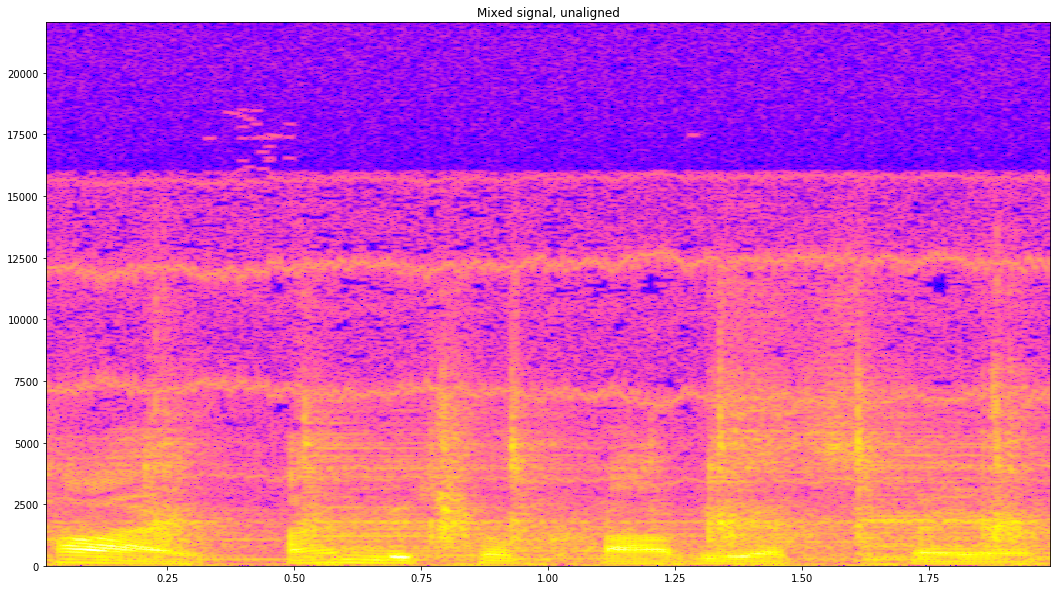

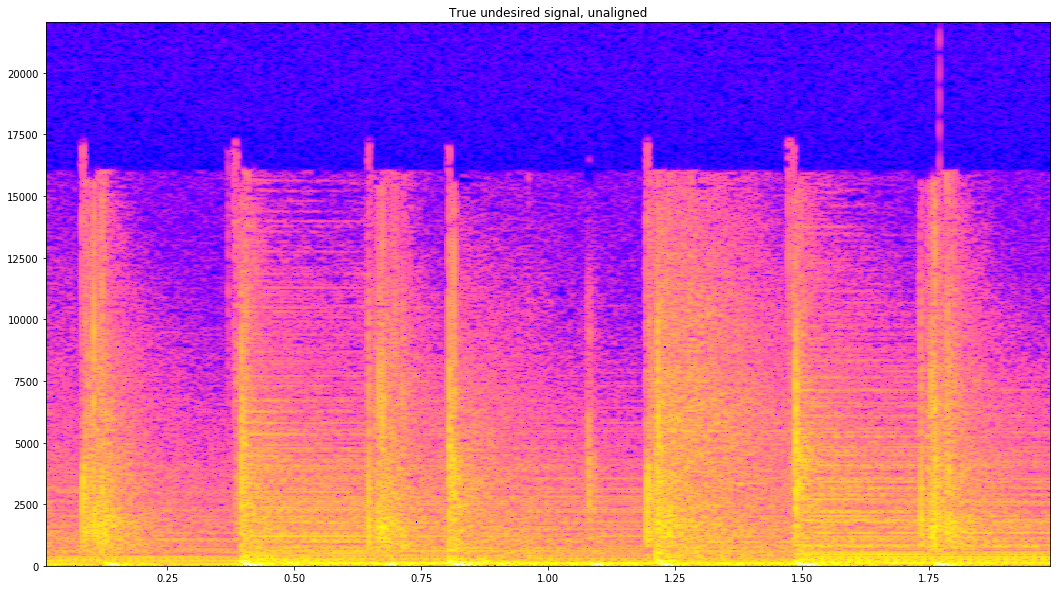

In [4]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
ax.set_title('Mixed signal, unaligned')
Pxx_Mix, freqs_Mix, bins_Mix, im_Mix = plt.specgram(MixedTimeseries, NFFT=1024, Fs=MixedRate, noverlap=900,cmap='gnuplot2')

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
ax.set_title('True undesired signal, unaligned')
Pxx_UndesiredTrue, freqs_UndesiredTrue, bins_UndesiredTrue, im_UndesiredTrue = plt.specgram(UndesiredTrueTimeseries, NFFT=1024, Fs=UndesiredTrueRate, noverlap=900,cmap='gnuplot2')

print('MixedTimeseries size = ' + str(MixedTimeseries.size))
print('MixedRate = ' + str(MixedRate))
print('Track len = ' + str(round(MixedTimeseries.size/MixedRate,2))+ ' s')
print('Pxx size = ' + str(Pxx_Mix.size))
print('freqs size = ' + str(freqs_Mix.size))
print('bins size = ' + str(bins_Mix.size))
print('---------------------------------')

print('UndesiredTrueTimeseries size = ' + str(UndesiredTrueTimeseries.size))
print('UndesiredTrueRate = ' + str(UndesiredTrueRate))
print('Track len = ' + str(round(UndesiredTrueTimeseries.size/UndesiredTrueRate,2))+ ' s')
print('Pxx size = ' + str(Pxx_UndesiredTrue.size))
print('freqs size = ' + str(freqs_UndesiredTrue.size))
print('bins size = ' + str(bins_UndesiredTrue.size))

## Observe spectrogram of the song alone (UndesiredTrue)

# Signal processing: identify temporal offset

## Manually pad the signals to be the same length

I don't like this approach, because the '0' paddings could cause anomalies in the matching (e.g. with silences in the recording or music). With my controlled demos, this is probably OK but roll-out will likely require a lag correlation method that is more robust to differences in length

In [5]:
padwidth = len(UndesiredTrueTimeseries)-len(MixedTimeseries);

if qVerbose > 0:
    print('UndesiredTrueTimeseries original length = ' + str(len(UndesiredTrueTimeseries)))
    print('MixedTimeseries original length = ' + str(len(MixedTimeseries)))           
    print('Padding Adjustment = ' + str(padwidth))

if padwidth < 0: 
    # mixed is longer than undesired; pad the song
    UndesiredTrueTimeseries = np.pad(UndesiredTrueTimeseries, abs(padwidth), 'constant')
    UndesiredTrueTimeseries = UndesiredTrueTimeseries[range(0, len(UndesiredTrueTimeseries)-abs(padwidth))]
                                            
elif padwidth > 0:
    # undesired is longer than mixed; pad the mix
    MixedTimeseries = np.pad(MixedTimeseries, padwidth, 'constant')
    MixedSongTimeseries = MixedSongTimeseries[range(0, len(MixedSongTimeseries)-padwidth)]

if qVerbose > 0:
    print('UndesiredTrueTimeseries length = ' + str(len(UndesiredTrueTimeseries)))
    print('MixedTimeseries length = ' + str(len(MixedTimeseries)))

UndesiredTrueTimeseries original length = 88200
MixedTimeseries original length = 88200
Padding Adjustment = 0
UndesiredTrueTimeseries length = 88200
MixedTimeseries length = 88200


## Define lagcorr

From https://stackoverflow.com/questions/9382207/specify-lag-in-numpy-correlate

Added `()`'s around print to update to python 3

In [6]:
def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print('\n#<lagcorr>: Computing lagged-correlations at lags:',lag)

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result

## Determine temporal offset from waveform

### Calculate the lag correlations (slow)

In [7]:
# Using LagCorr

# **********************************
# This is where there will be issues 
# if the two tracks are sampled at 
# different rates! That is because code
# assumes both tracks are at MixedRate

max_lag_N_inds =round(max_lag_s*MixedRate); # convert from s to frames
lag_ana = lagcorr(UndesiredTrueTimeseries,MixedTimeseries,verbose=True, lag = max_lag_N_inds)
lag_kata = lagcorr(UndesiredTrueTimeseries,MixedTimeseries,verbose=True, lag = -max_lag_N_inds)


#<lagcorr>: Computing lagged-correlations at lags: [    0     1     2 ..., 19843 19844 19845]

#<lagcorr>: Computing lagged-correlations at lags: [     0     -1     -2 ..., -19843 -19844 -19845]


### Extract maximum

In [8]:
# combine results
bidirectional_corr_coeffs = np.concatenate((lag_kata[::-1,0], lag_ana[:,0]))
bidirectional_p_values = np.concatenate((lag_kata[::-1,1], lag_ana[:,1]))
lag_timebase_frames = [i-max_lag_N_inds for i in range(max_lag_N_inds)]+[0, 0]+[i for i in range(max_lag_N_inds)]
lag_timebase_s = [i/max_lag_N_inds for i in lag_timebase_frames]

# find max correlation
max_cc_index, max_cc_value = max(enumerate(bidirectional_corr_coeffs), key=operator.itemgetter(1))
max_cc_s = lag_timebase_s[max_cc_index]
max_cc_indshift = round(max_cc_index-len(lag_timebase_s)/2);
cc_std = np.std(bidirectional_corr_coeffs)
cc_mean = np.mean(bidirectional_corr_coeffs)

if qVerbose >= 1:
    print('**********************************')
    if max_cc_s < 0:
        print('Mix lags behind undesired true')
    elif max_cc_s > 0:
        print('Mix ahead of undesired true')
    print('Temporal offset = '+str(round(max_cc_s,5))+' s (ind ',str(max_cc_indshift),')')
    print('@ max correlation coeff = '+str(round(max_cc_value,2)))
    print('which is ', str(round((max_cc_value-cc_mean)/cc_std,1)), ' stddev above mean')
    print('  (correlation mean:',str(round(cc_mean,5)),')')
    print('  (correlation stddev:',str(round(cc_std,5)),')')


**********************************
Mix lags behind undesired true
Temporal offset = -0.27166 s (ind  -5392 )
@ max correlation coeff = 0.1
which is  6.2  stddev above mean
  (correlation mean: 4e-05 )
  (correlation stddev: 0.0166 )


### Plot the correlations if qVerbose >= 2

Pulling some code from https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html#matplotlib.pyplot.subplot

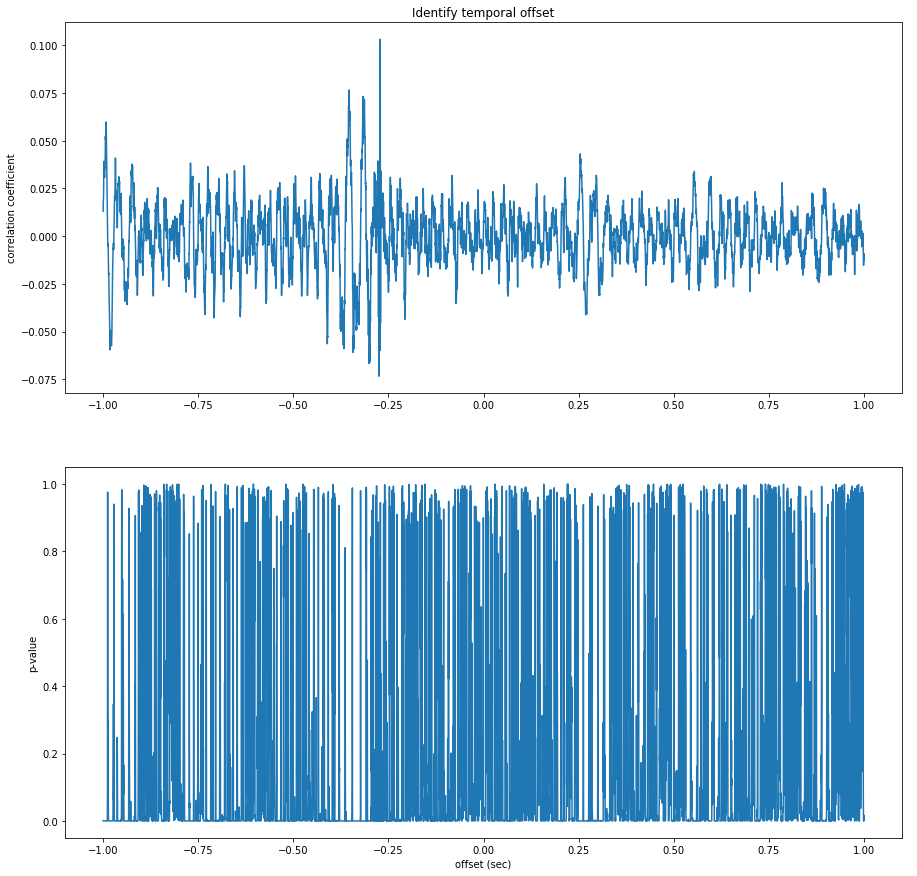

In [9]:
if qVerbose >= 2:
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)    # The big subplot
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    # Turn off axis lines and ticks of the big subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

    ax1.plot(lag_timebase_s,bidirectional_corr_coeffs)
    ax2.plot(lag_timebase_s,bidirectional_p_values)

    # Set common labels
    ax.set_xlabel('offset (sec)')
    ax1.set_ylabel('correlation coefficient')
    ax2.set_ylabel('p-value')

    ax1.set_title('Identify temporal offset')

    # plt.savefig('common_labels.png', dpi=300)


## Align the undesired signal to the mixed recording


In [10]:
shift_by_inds = abs(max_cc_indshift)

if max_cc_indshift < 1:
    #the undesired signal is ahead of the recording: so then pad the front of the undesired with zeroes and chop off the bac
    UndesiredTrueTimeseries_Aligned = np.pad(UndesiredTrueTimeseries, shift_by_inds, 'constant')
    UndesiredTrueTimeseries_Aligned = UndesiredTrueTimeseries_Aligned[0:(len(UndesiredTrueTimeseries_Aligned)-shift_by_inds*2)]

    
elif max_cc_indshift > 1:
    # converse
    pass

## Inspect alignment

/home/m/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


MixedTimeseries size = 88200
MixedRate = 44100
Track len = 2.0 s
Pxx size = 361152
freqs size = 513
bins size = 704
---------------------------------
UndesiredTrueTimeseries size = 88200
UndesiredTrueRate = 44100
Track len = 2.0 s
Pxx size = 361152
freqs size = 513
bins size = 704


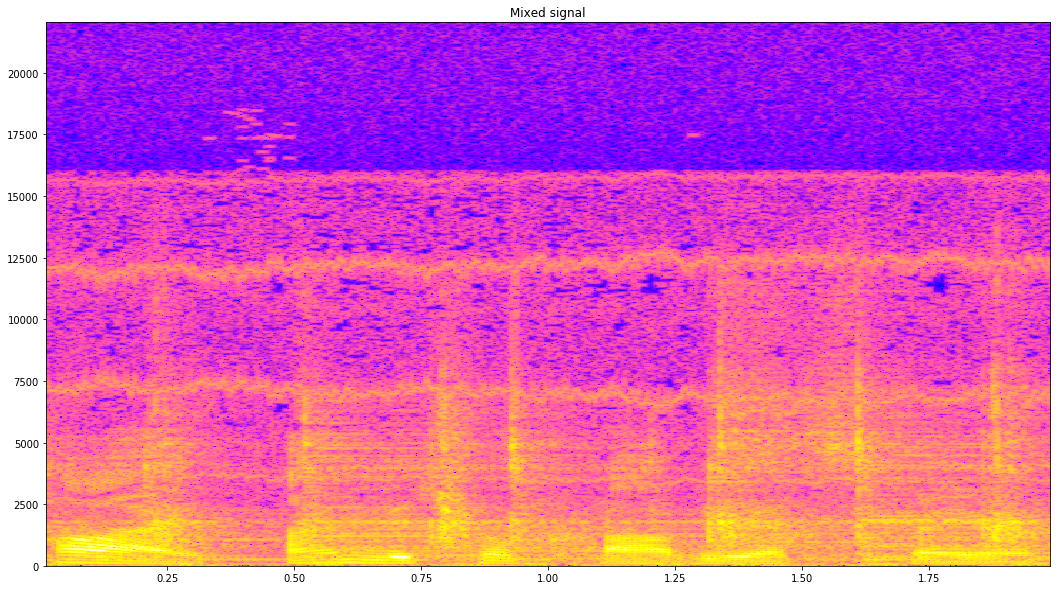

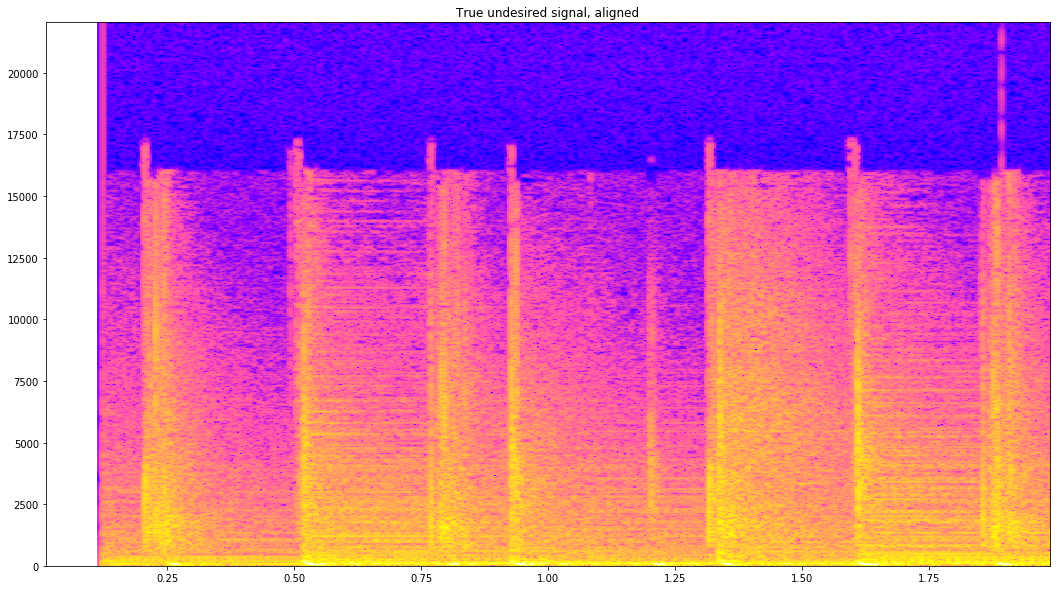

In [11]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
ax.set_title('Mixed signal')
Pxx_Mix, freqs_Mix, bins_Mix, im_Mix = plt.specgram(MixedTimeseries, NFFT=1024, Fs=MixedRate, noverlap=900,cmap='gnuplot2')
             
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
ax.set_title('True undesired signal, aligned')
Pxx_UndesiredTrue_Aligned, freqs_UndesiredTrue_Aligned, bins_UndesiredTrue_Aligned, im_UndesiredTrue_Aligned = plt.specgram(UndesiredTrueTimeseries_Aligned, NFFT=1024, Fs=UndesiredTrueRate, noverlap=900,cmap='gnuplot2')


print('MixedTimeseries size = ' + str(MixedTimeseries.size))
print('MixedRate = ' + str(MixedRate))
print('Track len = ' + str(round(MixedTimeseries.size/MixedRate,2))+ ' s')
print('Pxx size = ' + str(Pxx_Mix.size))
print('freqs size = ' + str(freqs_Mix.size))
print('bins size = ' + str(bins_Mix.size))
print('---------------------------------')

print('UndesiredTrueTimeseries size = ' + str(UndesiredTrueTimeseries_Aligned.size))
print('UndesiredTrueRate = ' + str(UndesiredTrueRate))
print('Track len = ' + str(round(UndesiredTrueTimeseries.size/UndesiredTrueRate,2))+ ' s')
print('Pxx size = ' + str(Pxx_UndesiredTrue_Aligned.size))
print('freqs size = ' + str(freqs_UndesiredTrue_Aligned.size))
print('bins size = ' + str(bins_UndesiredTrue_Aligned.size))

## Try the silly approach of simply subtracting the waveforms

In [12]:
if qSillyWaveformSubtraction == 1:
    for i in range(15):
        scale_factor = i/20;
        GuessDesired = MixedTimeseries - scale_factor*UndesiredTrueTimeseries_Aligned;
        fig = plt.figure(figsize=(18,10))
        ax = fig.add_subplot(111)
        ax.set_title('Mixed signal // scale_factor = '+str(scale_factor))
        Pxx_Mix, freqs_Mix, bins_Mix, im_Mix = plt.specgram(GuessDesired, NFFT=1024, Fs=MixedRate, noverlap=900,cmap='gnuplot2')

## Practice: Plot the spectral representation on its own

Note, I do not have an automatic adjustment for vmax yet. They are set arbitrarily

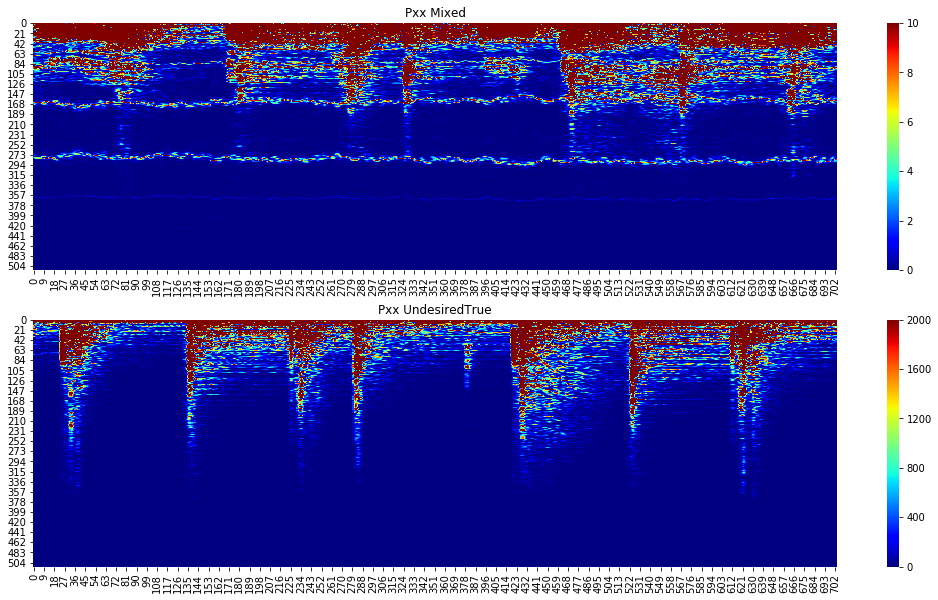

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(211)
ax.set_title('Pxx Mixed')
ax = sns.heatmap(Pxx_Mix,vmin=0, vmax=10, cmap='jet')

ax = fig.add_subplot(212)
ax.set_title('Pxx UndesiredTrue')
ax = sns.heatmap(Pxx_UndesiredTrue,vmin=0, vmax=2000, cmap='jet')

